<a href="https://colab.research.google.com/github/SepehrBazyar/QDVRP/blob/master/Quality_Driven_Vehicle_Routing_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Dependencies**

In [1248]:
!apt-get install -y -qq glpk-utils coinor-cbc

In [1249]:
!pip install gurobipy pyomo amplpy matplotlib

In [1250]:
!python3 -m amplpy.modules install coin highs scip gcg -q

**Import Libraries**

In [1251]:
import math
import random
import warnings
from abc import ABC
from dataclasses import dataclass, field

import pyomo.environ as pyo
import matplotlib.pyplot as plt
from amplpy import modules

In [1252]:
warnings.filterwarnings(action="ignore")

**Define Model**

In [1253]:
model = pyo.ConcreteModel()

**Parameters**

In [1254]:
@dataclass(unsafe_hash=True)
class Base(ABC):
  id: int

In [1255]:
@dataclass(unsafe_hash=True)
class Depot(Base):
  pass

In [1256]:
@dataclass(unsafe_hash=True)
class Product(Base):
  beta: float
  quality: float
  temperature: int

In [1257]:
@dataclass(unsafe_hash=True)
class Vehicle(Base):
  capacity: int
  time_window: int

  # Stochastics
  alpha_mu: float
  alpha_sigma: float

  salary_mu: float
  salary_sigma: float

  increase_rate: float = 0.005  # degrees per minute
  speed_rate: float = 1.5

  _salary: float = field(
    init=False,
    hash=False,
    default=None,
  )

  @property
  def salary(self):
    if self._salary is None:
      self._salary = random.gauss(
        mu=self.salary_mu,
        sigma=self.salary_sigma,
      )

    return self._salary

In [1258]:
@dataclass(unsafe_hash=True)
class Customer(Base):
  unload_rate: float = 0.5  # in minutes

  total_demand: int = field(
    init=False,
    hash=False,
    default=0,
  )

  @property
  def service_time(self):
    return self.unload_rate * self.total_demand

In [1259]:
temperature = 25

depot = Depot(id=0)
customers = (
  c1 := Customer(id=1),
  c2 := Customer(id=2),
  c3 := Customer(id=3),
  c4 := Customer(id=4),
  c5 := Customer(id=5),
  c6 := Customer(id=6),
  c7 := Customer(id=7),
)
nodes = depot, *customers

products = (
  p1 := Product(id=1, beta=0.1, quality=0.7, temperature=5),
  p2 := Product(id=2, beta=0.3, quality=0.85, temperature=3),
)

vehicles = (
  v1 := Vehicle(
    id=1,
    capacity=30,
    salary_mu=1.5,
    salary_sigma=0.1,
    alpha_mu=4.0,
    alpha_sigma=1.0,
    time_window=100,
  ),
  v2 := Vehicle(
    id=2,
    capacity=25,
    salary_mu=2.5,
    salary_sigma=0.15,
    alpha_mu=5.0,
    alpha_sigma=0.5,
    time_window=150,
  ),
  v3 := Vehicle(
    id=3,
    capacity=20,
    salary_mu=1.8,
    salary_sigma=0.12,
    alpha_mu=2.0,
    alpha_sigma=0.2,
    time_window=120,
  ),
)

demands = {
  (p1, c1): 3, (p1, c2): 5, (p1, c3): 2, (p1, c4): 7, (p1, c5): 4, (p1, c6): 6, (p1, c7): 8,
  (p2, c1): 2, (p2, c2): 3, (p2, c3): 1, (p2, c4): 2, (p2, c5): 4, (p2, c6): 2, (p2, c7): 3,
}
for (_, customer), demand in demands.items():
  customer.total_demand += demand

distances = {
  (depot, c1): 10,
  (depot, c2): 15,
  (depot, c3): 20,
  (depot, c4): 25,
  (depot, c5): 30,
  (depot, c6): 22,
  (depot, c7): 27,
  (c1, c2): 12, (c1, c3): 18, (c1, c4): 22, (c1, c5): 28, (c1, c6): 16, (c1, c7): 21,
  (c2, c3): 14, (c2, c4): 20, (c2, c5): 24, (c2, c6): 18, (c2, c7): 26,
  (c3, c4): 16, (c3, c5): 21, (c3, c6): 24, (c3, c7): 30,
  (c4, c5): 12, (c4, c6): 15, (c4, c7): 19,
  (c5, c6): 19, (c5, c7): 17,
  (c6, c7): 14,
}
distances.update({(j, i): d for (i, j), d in distances.items()})

**Decision Varibales**

In [1260]:
model.x = pyo.Var(nodes, nodes, vehicles, domain=pyo.Binary)
model.u = pyo.Var(customers, domain=pyo.NonNegativeReals)
model.t = pyo.Var(vehicles, domain=pyo.Reals)

In [1261]:
v = {(j, k): sum(model.x[i, j, k] for i in nodes if i != j) for j in customers for k in vehicles}
q = {(p, k): sum(demands.get((p, j), 0) * v[j, k] for j in customers) for p in products for k in vehicles}
t = {
  k: (
    sum(k.speed_rate * distances[i, j] * model.x[i, j, k] for i in nodes for j in nodes if i != j)
    +
    sum(j.service_time * v[j, k] for j in customers)
  ) for k in vehicles
}
d = {k: sum(j.service_time * k.increase_rate * v[j, k] for j in customers) for k in vehicles}

In [1262]:
decay = {(p, k): p.beta * abs((model.t[k] + d[k]) - p.temperature) for p in products for k in vehicles}

**Objective Function**

Minimize the Total Distance Traveled & Costs

Maximize the Total Quality of Products in Vehicles

In [1263]:
delta = {k: abs(temperature - model.t[k]) for k in vehicles}

In [1264]:
def cost_objective_func(model):
  distance_cost = sum(
    distances[i, j] * model.x[i, j, k] * 1  # per unit
    for i in nodes for j in nodes for k in vehicles if i != j
  )
  salary_cost = sum(k.salary * t[k] for k in vehicles)
  cooling_cost = sum(
    k.alpha_mu * delta[k] - pyo.sqrt(k.alpha_sigma * delta[k] ** 2)
    for k in vehicles
  )
  return distance_cost + salary_cost + cooling_cost

In [1265]:
def decay_objective_func(model):
  return sum(100 * decay[p, k] for p in products for k in vehicles)

In [1266]:
def combined_objective_func(model, w1, w2):
  total_cost = cost_objective_func(model)
  total_decay = decay_objective_func(model)
  return w1 * total_cost + w2 * total_decay

In [1267]:
step = 2
weights = [(w1 := i / 10, round(1 - w1, 1)) for i in range(1, 10, step)]

**Constraints**

Each Customer Visited Exactly Once by Exactly One Vehicle

In [1268]:
def visit_once_rule(model, j: Customer):
  has_demand = 1 if j.total_demand > 0 else 0
  return sum(v[j, k] for k in vehicles) == has_demand

In [1269]:
model.visit_once = pyo.Constraint(customers, rule=visit_once_rule)

Flow Conservation

If a Vehicle Enters a Node, It Must Leave It.

In [1270]:
def flow_conservation_rule(model, j: Customer | Depot, k: Vehicle):
    come_in = sum(model.x[i, j, k] for i in nodes if i != j)
    outside = sum(model.x[j, i, k] for i in nodes if i != j)
    return come_in == outside

In [1271]:
model.flow_conservation = pyo.Constraint(nodes, vehicles, rule=flow_conservation_rule)

Start & End at The Depot For Each Vehicle

In [1272]:
def start_depot_rule(model, k: Vehicle):
    return sum(model.x[depot, i, k] for i in customers) <= 1


def end_depot_rule(model, k: Vehicle):
    return sum(model.x[i, depot, k] for i in customers) <= 1

In [1273]:
model.start_depot = pyo.Constraint(vehicles, rule=start_depot_rule)
model.end_depot = pyo.Constraint(vehicles, rule=end_depot_rule)

Vehicle Capacity Constraints

In [1274]:
def capacity_rule(model, k: Vehicle):
    return sum(q[p, k] for p in products) <= k.capacity

In [1275]:
model.capacity = pyo.Constraint(vehicles, rule=capacity_rule)

Subtour Elimination

Miller-Tucker-Zemlin Formula

In [1276]:
def subtour_elimination_rule(model, i: Customer, j: Customer, k: Vehicle):
    if i != j and i != depot and j != depot:
        return model.u[i] - model.u[j] + len(customers) * model.x[i, j, k] <= len(customers) - 1

    return pyo.Constraint.Skip

In [1277]:
model.subtour_elimination = pyo.Constraint(customers, customers, vehicles, rule=subtour_elimination_rule)

Quality Maintaining

In [1278]:
def quality_maintaining_rule(model, p: Product, k: Vehicle):
  try:
    is_contained = q[p, k] / q[p, k]
  except ZeroDivisionError:
    is_contained = 0

  return 1 - decay[p, k] * is_contained >= p.quality

In [1279]:
model.quality_maintaining = pyo.Constraint(products, vehicles, rule=quality_maintaining_rule)

Time Window

In [1280]:
def time_window_rule(model, k: Vehicle):
  return t[k] <= k.time_window

In [1281]:
model.time_window = pyo.Constraint(vehicles, rule=time_window_rule)

**Solve the Model**

In [1282]:
SOLVERS = (
  "cbc",
  "highs",
  "couenne",
  "bonmin",
  "ipopt",
  "scip",
  "gcg",
)

In [1283]:
solver_name = SOLVERS[5]

In [1284]:
# solver = pyo.SolverFactory("glpk")  # linear
solver = pyo.SolverFactory(
  solver_name + "nl",
  executable=modules.find(solver_name),
  solve_io="nl",
)

In [1285]:
cost_values, decay_values = [], []
for w1, w2 in weights:
  if hasattr(model, "obj"):
    model.del_component(model.obj)

  model.obj = pyo.Objective(
    rule=lambda model: combined_objective_func(model, w1, w2),
    sense=pyo.minimize,
  )
  solver.solve(model)

  cost_values.append(pyo.value(cost_objective_func(model)))
  decay_values.append(pyo.value(decay_objective_func(model)))

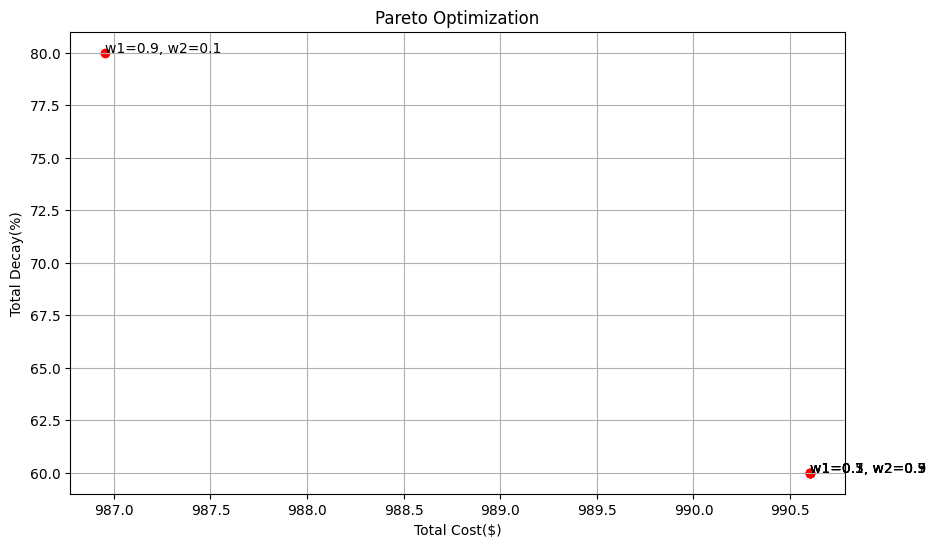

In [1286]:
plt.figure(figsize=(10, 6))
plt.scatter(cost_values, decay_values, color="red")
for (w1, w2), cost_value, decay_value in zip(weights, cost_values, decay_values):
    plt.annotate(f"{w1=}, {w2=}", (cost_value, decay_value))

plt.xlabel("Total Cost($)")
plt.ylabel("Total Decay(%)")
plt.title("Pareto Optimization")
plt.grid()
plt.show()

**Display Results**

In [1287]:
def get_path(router: dict[Customer, Customer], *, d: Depot = depot):
  order, next = [], router.get(depot, depot)
  while next != depot:
    order.append(str(next.id))
    next = router[next]

  if len(order) == 0:
    return "-"

  return " -> ".join((str(depot.id), *order, str(depot.id)))

In [1288]:
for k in vehicles:
  router = {}
  for i in nodes:
    for j in nodes:
      if i != j and round(pyo.value(model.x[i, j, k])) == 1:
        router[i] = j

  t_k = round(pyo.value(model.t[k]), ndigits=4)
  print(f"Vehicle {k.id} ({t_k:.4f}C): {get_path(router, d=depot)}")

Vehicle 1 (3.4600C): 0 -> 1 -> 2 -> 3 -> 0
Vehicle 2 (3.4525C): 0 -> 6 -> 7 -> 0
Vehicle 3 (2.9575C): 0 -> 4 -> 5 -> 0


In [1289]:
print(f"Total Costs: {round(pyo.value(cost_objective_func(model)), ndigits=4)}$")

Total Costs: 986.9555$


In [1290]:
for p in products:
  print(f"Product {p.id}:")
  for k in vehicles:
    percent = pyo.value(decay[p, k]) * 100
    print(f"Vehicle {k.id}:", round(100 - percent, 2), "%")

  print()

Product 1:
Vehicle 1: 85.0 %
Vehicle 2: 85.0 %
Vehicle 3: 80.0 %

Product 2:
Vehicle 1: 85.0 %
Vehicle 2: 85.0 %
Vehicle 3: 100.0 %

